# Business Case - 4Intelligence 

## Model

In [122]:
# installing libs and packages

!pip install sklearn -q
!pip install xgboost -q
#!pip install fbprophet -q

In [134]:
# importing libs

import pandas as pd
import numpy as np
from numpy import mean, median
from datetime import datetime , date
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.linear_model import LinearRegression ,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset

data_path = 'E:\\Projects\\4intelligence_case\\data\\Bases_Final_ADS_Jun2021.xlsx'
df = pd.read_excel(data_path, sheet_name='dados')

In [113]:
# target feature

# setting date in index
df_time = df.set_index('data_tidy')
df_time = df_time.loc[df_time['ind_se']!=0]

time_series_ind_se = df_time['ind_se']
time_series_ind_se.index = pd.to_datetime(time_series_ind_se.index, errors='coerce')

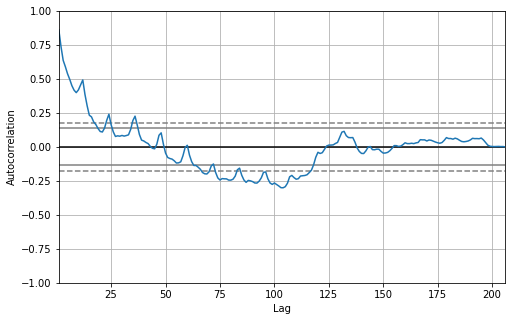

In [130]:
# autocorrelation plot in target feature
# checking randomness
rcParams['figure.figsize'] = 8, 5
autocorrelation_plot(time_series_ind_se)
plt.show()

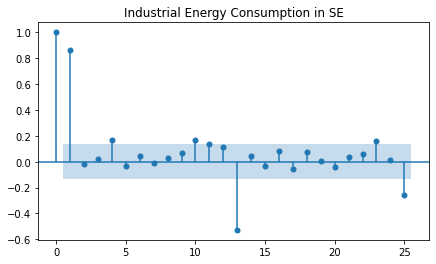

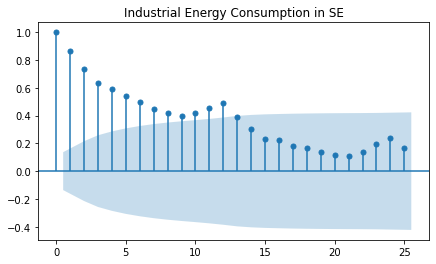

In [137]:
# autocorrelation and autocorrelation partial plots
# try to identify the best "p" and "q" to arima model params

rcParams['figure.figsize'] = 7, 4
plot_pacf(time_series_ind_se,lags=25,title='Industrial Energy Consumption in SE')
plot_acf(time_series_ind_se,lags=25,title='Industrial Energy Consumption in SE')
plt.show()

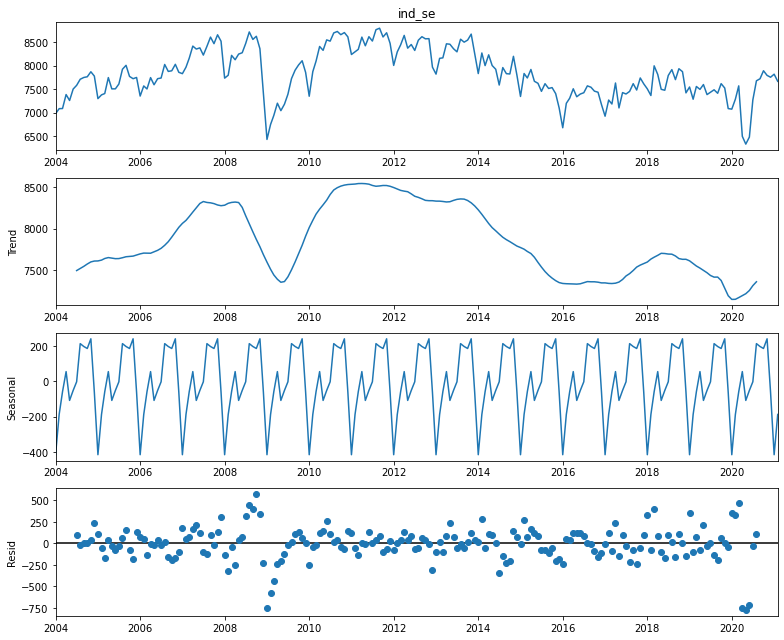

In [114]:
# decompose the energy in trend, seasonal and resids to know main trend and the frequent moviments
# statiscal analyze
# Industrial energy consumption in SE

rcParams['figure.figsize'] = 11, 9
decomposed_indse_energy = sm.tsa.seasonal_decompose(time_series_ind_se) # The frequncy is annual
figure = decomposed_indse_energy.plot()
plt.show()

## Feature Engineering

In [4]:
# change datetime to date
df['data_tidy'] = df['data_tidy'].apply(lambda x: x.date())

In [5]:
# replace nan values to zero
df = df.fillna(0)

In [6]:
# creating year, month features

df['ano'] = df['data_tidy'].apply(lambda x: x.year)
df['mes'] = df['data_tidy'].apply(lambda x: x.month)

In [7]:
# creating new features

# total energy consumed by business category
df['com_total'] = df['com_co'] + df['com_n'] + df['com_ne'] + df['com_s'] + df['com_se']

# total energy consumed by industrial category
df['ind_total'] = df['ind_co'] + df['ind_n'] + df['ind_ne'] + df['ind_s'] + df['ind_se']

# total energy consumed by residential category
df['res_total'] = df['res_co'] + df['res_n'] + df['res_ne'] + df['res_s'] + df['res_se']

# total energy consumed
df['total'] = df['res_total'] + df['ind_total'] + df['com_total']

In [8]:
# creating new features about each region
# consumption total by region

# SE
df['se_total'] = df['com_se'] + df['ind_se'] + df['com_se']
# S
df['s_total'] = df['com_s'] + df['ind_s'] + df['com_s']
# NE
df['ne_total'] = df['com_ne'] + df['ind_ne'] + df['com_ne']
# N
df['n_total'] = df['com_n'] + df['ind_n'] + df['com_n']
# CO
df['co_total'] = df['com_co'] + df['ind_co'] + df['com_co']

In [9]:
# new features about temperature

# max tempearature in Brazil
df['max_temp'] = df[['temp_max_n','temp_max_ne','temp_max_co','temp_max_se','temp_max_s']].max(axis =1)
# min tempearature in Brazil
df['min_temp'] = df[['temp_max_n','temp_max_ne','temp_max_co','temp_max_se','temp_max_s']].min(axis =1)
# delta - the difference
df['delta'] = df['max_temp'] - df['min_temp']
# the mean -min-max
df['media_temp'] = (df['max_temp'] + df['min_temp'])/2

In [117]:
# split train dataset

df_train = df.loc[df['data_tidy'] <= date(2021,2,1)]
df_val = df.loc[df['data_tidy'] > date(2021,2,1)]

In [11]:
# creating correlation matrix
mc = df_train.corr(method = 'pearson')

In [12]:
# strongests correlations between industrial energy consumption SE
mc['ind_se'].sort_values(ascending=False)

ind_se         1.000000
ind_total      0.885493
pim_se         0.793250
ind_ne         0.754299
pim_s          0.683477
pim_ne         0.450059
pim_n          0.316463
se_total       0.313763
pmc_a_co       0.301078
ne_total       0.287529
mes            0.281097
pmc_a_ne       0.229778
pmc_a_se       0.218574
pmc_r_co       0.216244
ind_s          0.201316
delta          0.192139
max_temp       0.181328
temp_max_n     0.180960
pmc_a_n        0.156524
pmc_r_ne       0.130908
temp_max_co    0.116144
ind_n          0.104751
pmc_a_s        0.102949
pmc_r_n        0.067781
total          0.060419
pim_co         0.047890
pmc_r_se       0.046026
pop_ocup_br    0.044074
du             0.036097
temp_max_ne   -0.011721
s_total       -0.019891
n_total       -0.036934
pmc_r_s       -0.059158
temp_max_se   -0.076352
com_se        -0.088309
ind_co        -0.091900
co_total      -0.108182
media_temp    -0.110655
com_co        -0.115085
com_total     -0.123896
res_se        -0.127810
temp_min_ne   -0

In [65]:
# selecting features and target

features = df_train[['pim_se','ind_ne','massa_r','renda_r']]

label = df_train['ind_se'].values

In [66]:
# scalling features

scaler = StandardScaler()
features = scaler.fit_transform(features)

In [67]:
# splitting the features

train_features, test_features, train_labels, test_labels = train_test_split(features , label, 
                                                                            test_size = 0.25, 
                                                                            random_state = 0)

In [68]:
# model 1: Linear Regression

model1 = LinearRegression()
model1.fit(train_features, train_labels)

LinearRegression()

In [69]:
# predictions

predictions = model1.predict(test_features)

In [70]:
# evaluate the model 1

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('Linear Regression MAE: ', mae)
print('Linear Regression MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))


Linear Regression MAE:  191.2077749368664
Linear Regression MSE:  60394.7139623759
Coefficient of determination: 0.72


In [71]:
# model 2: ElasticNet

model2 = ElasticNet()

# test all hyperparams below
param_grid = [{'l1_ratio':[0.25, 0.5, 0.75, 1],
               'max_iter':[500, 750, 1000, 2000, 5000]}]

# exhaustive search for best params
GS = GridSearchCV(model2 , param_grid , scoring= 'neg_mean_absolute_error' , error_score= 'raise', cv=5)
GS.fit(train_features, train_labels)
print(GS.best_params_)

{'l1_ratio': 1, 'max_iter': 500}


In [72]:
# model 2 with best params

model2 = ElasticNet(l1_ratio = GS.best_params_['l1_ratio'] , 
                    max_iter = GS.best_params_['max_iter'])

model2.fit(train_features , train_labels)
predictions = model2.predict(test_features)

In [73]:
# evaluate the model 2

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('ElasticNet MAE: ', mae)
print('ElasticNet MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))


ElasticNet MAE:  194.52254272095595
ElasticNet MSE:  62915.55858418738
Coefficient of determination: 0.71


In [76]:
# model 2: Random Forest

model3 = RandomForestRegressor()

# test all hyperparams below
param_grid = [{'n_estimators':[35,40,45,50,55,60,70,80,90,100,150,180,220,250,280],
               'max_depth':[3,5,6,7,8,9,10,11,12]}]

# exhaustive search for best params
GS = GridSearchCV(model3 , param_grid , scoring= 'neg_mean_absolute_error' , error_score= 'raise', cv=5)
GS.fit(train_features, train_labels)
print(GS.best_params_)

{'max_depth': 5, 'n_estimators': 50}


In [77]:
# model 3 with best params

model3 = RandomForestRegressor(n_estimators = GS.best_params_['n_estimators'] , 
                            max_depth = GS.best_params_['max_depth'])

model3.fit(train_features , train_labels)
predictions = model3.predict(test_features)

In [78]:
# evaluate the model 3

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('Random Forest MAE: ', mae)
print('Random Forest MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))


Random Forest MAE:  211.37414761596972
Random Forest MSE:  72349.94748516087
Coefficient of determination: 0.67


In [83]:
# model 4: Gradient descent

model4 = XGBRegressor()

# test all hyperparams below
param_grid = [{'max_depth':[4,5,6,7,8,9,10,11,12,13],
               'n_estimators':[150,180,200,220],
               'objective':['reg:squarederror'],
               'eval_metric':['mae'],
               'booster':['gbtree'],
               'learning_rate':[0.5,0.7,0.9]}]

# exhaustive search for best params
GS = GridSearchCV(model4 , param_grid , scoring= 'neg_mean_absolute_error' , error_score= 'raise', cv=5)
GS.fit(train_features, train_labels)
print(GS.best_params_)

{'booster': 'gbtree', 'eval_metric': 'mae', 'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 150, 'objective': 'reg:squarederror'}


In [ ]:
# model 4 with best params

model4 = XGBRegressor(n_estimators = GS.best_params_['n_estimators'] , 
                    max_depth = GS.best_params_['max_depth'],
                    objective = GS.best_params_['objective'],
                    eval_metric = GS.best_params_['eval_metric'],
                    booster = GS.best_params_['booster'],
                    learning_rate = GS.best_params_['learning_rate'])

model4.fit(train_features , train_labels)
predictions = model4.predict(test_features)

In [84]:
# evaluate the model 4

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('Gradient Descent MAE: ', mae)
print('Gradient Descent MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))


Gradient Descent MAE:  211.37414761596972
Gradient Descent MSE:  72349.94748516087
Coefficient of determination: 0.67


In [92]:
# model 5: Support Vector Machine

model5 = SVR()

param_grid = [{'kernel':['poly','rbf','sigmoid'],
               'degree':[1,2,3,4,5,6],
               'epsilon':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
               'C':[1,2,3,4,5,6,7,8,9]}]

# exhaustive search for best params
GS = GridSearchCV(model5 , param_grid , scoring= 'neg_mean_absolute_error' , error_score= 'raise', cv=5)
GS.fit(train_features, train_labels)
print(GS.best_params_)

{'C': 9, 'degree': 1, 'epsilon': 0.9, 'kernel': 'poly'}


In [93]:
# model 5 with best params

model5 = SVR(kernel= GS.best_params_['kernel'],
            degree= GS.best_params_['degree'],
            epsilon= GS.best_params_['epsilon'],
            C= GS.best_params_['C'])

model5.fit(train_features , train_labels)
predictions = model5.predict(test_features)

In [95]:
# evaluate the model 5

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('SVR MAE: ', mae)
print('SVR MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))


SVR MAE:  239.08190586140998
SVR MSE:  81572.66070480624
Coefficient of determination: 0.62


In [96]:
# model 6: Neural Netwoks

model6 = MLPRegressor()

param_grid = [{'activation':['relu'],'solver':['lbfgs'],'alpha':[0.01],
               'hidden_layer_sizes':[(100,100),(50),(50,50,50)],
               'max_iter':[250,500],
               'learning_rate':['constant', 'invscaling', 'adaptive'],
               'tol':[0.01]}]

# exhaustive search for best params
GS = GridSearchCV(model6 , param_grid , scoring= 'neg_mean_absolute_error' , error_score= 'raise', cv=5)
GS.fit(train_features, train_labels)
print(GS.best_params_)

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 50, 'learning_rate': 'constant', 'max_iter': 250, 'solver': 'lbfgs', 'tol': 0.01}


In [100]:
# model 6 with best params

model6 = MLPRegressor(activation= GS.best_params_['activation'],
                        alpha= GS.best_params_['alpha'],
                        hidden_layer_sizes= GS.best_params_['hidden_layer_sizes'],
                        learning_rate= GS.best_params_['learning_rate'],
                        max_iter= GS.best_params_['max_iter'],
                        solver= GS.best_params_['solver'],
                        tol= GS.best_params_['tol'])

model6.fit(train_features , train_labels)
predictions = model5.predict(test_features)

In [101]:
# evaluate the model 6

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('Neural Networks MAE: ', mae)
print('Neural Networks MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))


Neural Networks MAE:  239.08190586140998
Neural Networks MSE:  81572.66070480624
Coefficient of determination: 0.62
